In [1]:
import re

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

c:\users\jurus\desktop\machine learing lab auta\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#DATA

df_fake = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/Fake.csv")
df_true = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/True.csv")

# Adding a column to indicate whether the news is true or fake
df_true['isfake'] = 0
df_fake['isfake'] = 1

df_1 = pd.concat([df_true, df_fake]).reset_index(drop=True)
df_1.drop(columns=['date'], inplace=True)

# Combining 'title' and 'text' colmuns together
#df['original'] = df['tweet']
df_1['original'] = df_1['title'] + ' ' + df_1['text']

In [4]:
df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data/Constraint_Train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data/english_test_with_labels.csv")

df_2 = pd.concat([df_train, df_test]).reset_index(drop=True)

#Changing labels: real to 1 and false to 0
df_2['label'] = df_2['label'].replace({'real': 1})
df_2['label'] = df_2['label'].replace({'fake': 0})
df_2['isfake'] = df_2['label']
counter_fake = 0
counter_true = 0
for ind in df_2.index:
    if df_2['label'][ind] == 0:
        counter_true+=1
    elif df_2['label'][ind] == 1:
        counter_fake+=1

# Combining 'title' and 'text' colmuns together
df_2.drop(columns=['label'], inplace=True)
df_2['original'] = df_2['tweet']
df_2.drop(columns=['tweet'], inplace=True)
df_2['clean'] = df_2['original'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)



In [5]:
df_2.drop(columns=['original'], inplace=True)
df_2['original'] = df_2['clean']
df_2.drop(columns=['clean'], inplace=True)
df_2.drop(columns=['id'], inplace=True)

In [6]:
df_1.drop(columns=['title'], inplace=True)
df_1.drop(columns=['text'], inplace=True)
df_1.drop(columns=['subject'], inplace=True)

In [7]:
df = pd.concat([df_1, df_2]).reset_index(drop=True)
df

isfake                                           original
0           0  As U.S. budget fight looms, Republicans flip t...
1           0  U.S. military to accept transgender recruits o...
2           0  Senior U.S. Republican senator: 'Let Mr. Muell...
3           0  FBI Russia probe helped by Australian diplomat...
4           0  Trump wants Postal Service to charge 'much mor...
...       ...                                                ...
53453       1  #CoronaVirusUpdates: State-wise details of Tot...
53454       0  Tonight 12(midnight) onwards Disaster Manageme...
53455       1  296 new cases of #COVID19Nigeria; Plateau-85 E...
53456       1  RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...
53457       1  More than half of pregnant women recently admi...

[53458 rows x 2 columns]

In [8]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['washington', 'reuters', 'video', 'tweet', 'tweets'])

# Removing stopwords and words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

df['clean'] = df['original'].apply(preprocess)

# All unique words present in dataset in one string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

0        budget fight looms republicans flip fiscal scr...
1        military accept transgender recruits monday pe...
2        senior republican senator mueller special coun...
3        russia probe helped australian diplomat trump ...
4        trump wants postal service charge amazon shipm...
                               ...                        
53453    state wise details total confirmed covid cases...
53454    tonight midnight onwards disaster management i...
53455    cases covid nigeria plateau enugu lagos rivers...
53456    cdcemergency cdcgov stop shop covid resources ...
53457    half pregnant women recently admitted hospital...
Name: clean_joined, Length: 53458, dtype: object


In [9]:
df['clean_joined'][53457]

'half pregnant women recently admitted hospital covid infection black ethnic minority groups study finds'

In [10]:
#COUNT VECTORIZER - counts  the occurrence of each word for every single text in order to create a vector

from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size=0.2)

vectorizer = CountVectorizer()
vectorizer.fit(df['clean_joined'])
# Transforming training and validation data using count vectorizer object
X_train_count = vectorizer.transform(X_train.values)
X_test_count = vectorizer.transform(X_test.values)


Model accuracy is :  0.8994575383464273
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5023
           1       0.89      0.92      0.91      5669

    accuracy                           0.90     10692
   macro avg       0.90      0.90      0.90     10692
weighted avg       0.90      0.90      0.90     10692



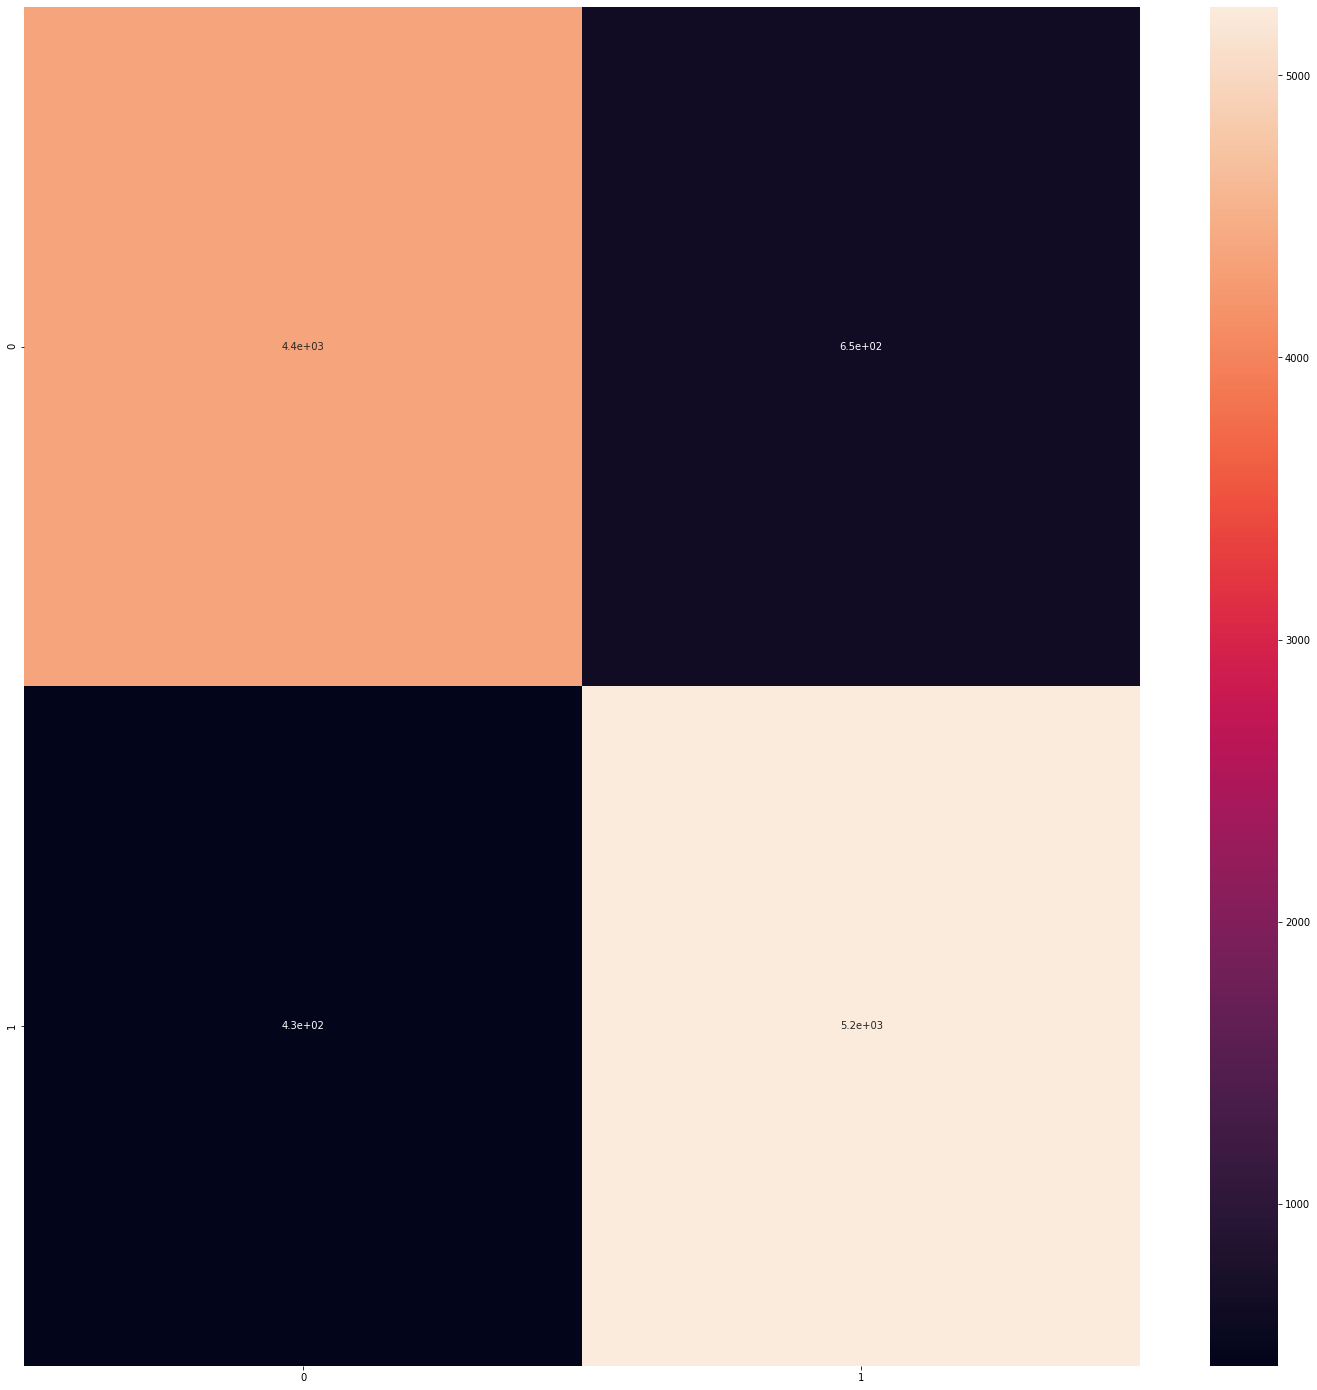

In [11]:
# NAIVE BAYES CLASSIFIER

from sklearn import naive_bayes

model = naive_bayes.MultinomialNB()
model.fit(X_train_count, y_train)

## Plot confusion matrix

pred = model.predict(X_test_count)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

In [12]:
df_pred = pd.DataFrame(pred, columns = ['output'])

In [13]:
for X,Y,Z in zip(pred, y_test, X_test):
    print("Model Score:", X, "\nactual score:", Y, "\ntext:", Z, "\n-----------------------") 

Model Score: 1 
actual score: 1 
text: walmart forced apologize store tells kids school guns walmart school advertising took pretty horrible turn location evansville indiana chain apologetic incessant need guns readily available customers felt store went school display encouraging kids school year like hero spot people arms speak walmart things twitter hdlpg jmyw frank passalacqua randomfrankp august right color backdrop lighter blue clashes photo especially gigantic display case guns thinking person viewing display serves reminder school shootings regularly plague nation thanks republicans resistance form sensible control republicans guns school walmart refuses word easy availability guns social media person hopped damage control sign sign business taken soon alerted spokesperson calling dean tweeted response photo sorry terrible jordan sign business taken soon alerted sorry dean walmart walmart august good walmart apologized important remember walk stores pick eggs milk shotgun assau

text: absence vaccine pharmaceutical interventions face masks physical distancing hand hygiene remain effective strategy limit covid spread boss mustapha ptfcovid chairman livestream ongoing press briefing 
-----------------------
Model Score: 1 
actual score: 1 
text: msnbc sources network disturbed scarborough love donald trump political pundit scarborough donald trump problem makes msnbc scarborough problem networks including ultra conservatives news combative republican runner trump msnbc scarborough cozying unapologetic bigot progressive network extremely worried thing conservative pundit represent aisle turning racist sexist demagogue dylan byers spoke numerous sources msnbc broad agreement scarborough embarrassing network trump love background discussions news msnbc journalists reporters staffers said widespread discomfort network scarborough friendship trump increasingly favorable coverage candidate people like promoting trump msnbc insider said described scarborough admiration

-----------------------
Model Score: 0 
actual score: 0 
text: huckabee says attend trump event veterans iowa arkansas governor mike huckabee candidate republican presidential nomination said thursday attend event military veterans organized iowa republican runner donald trump reported york businessman trump involved spat news vowed skip thursday night republican presidential debate hosted network instead said hold event benefit military veterans said huckabee participate republican debate trump event reporting david alexander ryan susan heavey editing david gregorio sponsor coverage independently produced staff news agency 
-----------------------
Model Score: 1 
actual score: 0 
text: survived homeschooling lockdown shirt assuming survived homeschooling obviously 
-----------------------
Model Score: 1 
actual score: 1 
text: intel chair stands dems calling ouster democrats want quit effective getting things rep_devinnunes sure thedemocrats want quit know effective getting things twi

actual score: 1 
text: incompetent trump begged thanksgiving guests advice secretary state know president elect donald trump idea role increasingly dangerous appoints billionaires white supremacists cabinet advice basically racist supporters recent report giving insight trump chose secretary state according source spoke york post trump left decision thanksgiving party guests york post reported attended trump thanksgiving dinner party lago club florida recalled moment trump sitting eating family running asking club members pick secretary state source said donald walking asking everybody secretary state criticism mitt romney people like rudy giuliani people advocating john bolton featured image mcnamee getty images 
-----------------------
Model Score: 1 
actual score: 1 
text: paul ryan republicans tolerate democratic disruption house democrats house representatives week showed level spine slimy weasel speaker house paul ryan know staged civil rights icon john lewis floor house represen

text: watch trump surrogate tries defend trump sacrifice interview fails hard trap messaging trump campaign decided asked trump response father muslim died serving american army captain overseas narrative trump campaign uses trump says horrible camera media twisted words trump surrogates scottie nell hughes tried tactic segment sunday morning father khizr khan spoke democratic national convention called trump proposal muslims entering united states khan said speech trump sacrificed life trump billionaire responded saying think sacrifices work hard created thousands thousands jobs tens thousands jobs built great structures tremendous success think response came interview george stephanopoulos hughes says initially disappointed trump comments khan realized interview media agenda trump look apparently mind trump supporter tell people truth giant media conspiracy read questions trump campaign released transcript setup trap trump going forward truth trump trapped trapped vile rhetoric spewe

actual score: 1 
text: obama fights radical agenda alive asks crooked loretta lynch challenge supreme court decision blocked executive order amnesty scheme good reminder important prevent obama anointing radical supreme court good time american representatives keeping radical obama appointee supreme court literally thing standing free america looks like venezuela reminder republican party considers trump movement democrat party closer fundamentally changing america forever obama administration looking challenge supreme court decision block president barack obama plan spare millions illegal immigrants deportation attorney general loretta lynch said tuesday reviewing case seeing need court lynch told interview lynch legal options obama administration pursue following split decision supreme court justices week left place block executive action lower court said future executive actions obama immigration left white house wideranging interview topics control effect planned exit britain europ

Model Score: 0 
actual score: 0 
text: obama praises argentina hurry macri reforms buenos aires president barack obama wednesday championed argentina center right leader mauricio macri example countries latin america praising fast pace reforms strengthen economy obama visit argentina marks detente years tensions said argentina macri poised play influential role global stage days office macri distanced south america leftist bloc allies president cristina fernandez sought thaw relations western capitals seeks investment latin america economy tell president macri hurry obama told joint news conference leaders held talks impressed moved rapidly reforms promised create sustainable inclusive economic growth reconnect argentina global economy world community said macri offers obama ally south america region strong leftist bloc turned past decade public opinion shifting political center governments grapple graft scandals economic slowdown argentina assuming traditional leadership role region w

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0 
actual score: 0 
text: moscow blames faced policy russian general syria death moscow russian deputy foreign minister sergei ryabkov said monday faced policy united states blame death russian lieutenant general valery asapov syria news agency quoted saying russian defence ministry said sunday asapov killed islamic state shelling near deir moscow complained suggested suspiciously friendly ties backed militias special forces islamic state area accusing trying slow advance syrian army death russian commander price bloody price faced american policy syria ryabkov told reporters according ryabkov questioned intention fight islamic state syria american declares interested elimination actions opposite political geopolitical goals important ryabkov quoted saying earlier monday american backed syrian militias said russian warplanes struck positions deir province near natural field seized islamic state week russia denied ryabkov said russia wanted strengthen international atomic energy agency 

text: army veteran incredible thanksgiving smack spoiled brat anthem kneelers goes viral thanksgiving like address open letter national football league players continue knee star spangled banner played dear kneeling brothers proud army veteran black american thank live greatest nation earth thanksgiving come year thankful days year money americans regardless race kids look heroes appear media protesting refusing rise respect national anthem respect women like serve served military willing country army uniform willing stand short song sacrifice lessons learned place planet like america perfect perfect consummate beacon light hill nations look hope dignity direction guys appreciate pause moments express patriotism love great nation national anthem played flag flies thousands people paid good money field chasing little ball tell strong stepped forward join army fight right play games peace weeks graduated army basic training program epiphany deployed life line long come resounding called 

Model Score: 0 
actual score: 0 
text: russian suspect detained arson attacks tsar film moscow russian court ordered detention saturday suspicion trying intimidate cinemas showing film country tsar russia news agencies said police said earlier opened criminal case following series arson attacks protest film matilda award winning director alexei uchitel film tells story love affair tsar nicholas half polish ballerina matilda kshesinskaya described relationship memoirs interfax cited court spokeswoman saying detained alexander kalinin leader radical religious group called christian state holy suspicion pressuring cinemas screen movie court ordered held custody charge christian state vowed cinemas screened matilda series arson attacks connected film reported country matilda released internationally late october despite protests religious conservatives offended regard disrespectful depiction russian orthodox church regards martyr cinemas said showing film threats received criminal case ope

text: hillary clinton postpones trip charlotte campaign statement democratic presidential candidate hillary clinton postponed trip planned sunday charlotte north carolina seen violent protests black killed police earlier week hillary grateful intends honor invitation faith leaders visit charlotte community campaign said statement friday discussion community leaders decided postpone sunday trip impact city resources said adding clinton visit city following sunday 
-----------------------
Model Score: 1 
actual score: 1 
text: cleveland school officer placed leave horrible message tamir rice images officer cleveland school come posted status facebook called mother slain tamir rice stupid vile insensitive remarks young police brutality victims rice year cleveland shot killed year police officer timothy loehmann playing shot dead investigating situation fully week loehmann hook cleared charges filed days announcement cleveland metropolitan school district officer matt cicero decided voice 

text: precautionary message catch hand sanitizer high alcohol message shows hands lady applying sanitizer went near stove ended burning hands 
-----------------------
Model Score: 0 
actual score: 0 
text: ratan tata indian industrialist spoke indian economy bounce believe experts predicting slowdown 
-----------------------
Model Score: 0 
actual score: 0 
text: house members lower biofuels requirements york group members house representatives asked environmental protection agency letter thursday lower requirements mixing biofuels country fuel supply ethanol exports qualify renewable fuel credits according copy letter obtained members congress bipartisan voting bloc dedicated supporting biofuels industry called house biofuels caucus represent districts states iowa illinois farmers grow corn ethanol biofuels urged agency increase biomass based biodiesel requirements decrease advanced biofuels required added fuel supply farmers biofuels producers need greater certainty letter said addin

text: russia lavrov tillerson discuss syria russia moscow russian foreign minister sergei lavrov held phone syria crisis american counterpart tillerson ministry said statement friday lavrov tillerson spoke late thursday discussed cooperation attempts resolve syrian crisis emphasis escalation zones ministry said 
-----------------------
Model Score: 0 
actual score: 1 
text: usda want rethink removing country origin meat chinese meatpackers busted yuck china meat festival week usda removed country origin meat needs come asap meat smuggling going know originated china like informed choice meat reason chinese authorities seized tonnes smuggled meat years according state media frozen meat estimated worth million yuan seized nationwide crackdown smelly nearly threw opened door official hunan province tonnes seized told news agency poor standards food safety major concern china according state newspaper china daily officials guangxi southern region bordering vietnam meat dating thawed times 

actual score: 1 
text: college kneed anger trump remarks players disrespecting flag immediately gets news coach given option kneel protest game important stand president bravely taking public stance defense flag veterans liberal arts college eastern pennsylvania backup quarterback knelt national anthem albright college reading gyree durante team took knee star spangled banner according philadelphia inquirer according paper school promised consequences players took actions different special agreement team leadership council decided squad knee pregame coin toss stand national anthem knew consequences knew took knee good chance kicked like taking knee coin toss thought defeated purpose kneeing anthem team unity thing thought allowed individuals express week watching football happened remarks president trump players taking knee anthem said fired kicked things like knew issue racial social injustice know police brutality african americans things like heard president negative kinda struck ne

text: study pray vote pope tells americans ahead elections aboard papal plane pope francis sunday advised catholics feel torn imperfect candidates president study pray vote sure follow conscience traditional freewheeling flight news conference reporters plane returning azerbaijan francis asked counsel american faithful wisdom mind asked question describes difficult choice according difficulties difficulties pope said naming democrat hillary clinton republican donald trump posing question reporter allusions clinton support abortion trump statements vilifying migrants religious minorities political campaigns word pope said people sovereign study proposals pray choose conscience rest response stressing wanted talk fictional situation francis appeared saying united states countries politicized effectively lost called culture politics country candidates satisfy means political life country politicized political culture said people party party effectively clear thoughts basics proposals said

Model Score: 1 
actual score: 1 
text: phony patriotism defense department paid disgusting million field flag appearances welcome home tributes gives fans reason stop supporting agreed refund small portion money defense department taxpayers paid support military idea americans duped believing honor reverence military reached acceptance players disrespecting flag promote obama race disallowing dallas cowboys honor police officers slain hometown black lives matter terrorist forget looked away cleveland brown player isaiah crowell posted instagram picture neck slit open said word acknowledged considered terrorist type threat enforcement announced return taxpayers money paid teams sponsored military tributes criticized paid patriotism money came armed forces budget measures public recognition games commissioner roger goodell said league money letter written senators jeff flake john mccain wednesday disclosed thursday goodell said following audited review marketing agreements accounting fir

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 
actual score: 0 
text: house republicans reject bids obtain trump returns republican controlled congressional panel rejected democrats tuesday obtain president donald trump returns despite warnings trump business holdings pose conflicts congress turns reform fiery hour hearing careened lawmaker concerns political corruption national security privacy rights accounting house ways means committee voted party lines oppose democratic resolution sought release years trump returns house representatives hearing house republicans separately turned democratic attempt force floor vote trump returns committee republicans accused democrats writing committee political grandstanding resolution procedural tool utilized think abused obvious political purposes panel chairman kevin brady said democrats said exercising proper congressional oversight accused republicans protecting trump trump defied decades precedent refusing release returns saying affairs federal audit internal revenue service says audi

actual score: 0 
text: rival sues illinois house speaker dirty election tactics chicago vanquished challenger illinois house speaker michael madigan filed federal lawsuit monday longtime democratic leader accusing dirty tactics beat march primary election chicago democrat jason gonzales accused madigan defaming crowding primary phony candidates dilute opposition gonzalez named year incumbent speaker political funds aide opponents count lawsuit alleged scheme swing race speaker favor madigan engaged dirty illegal fraudulent tactics gonzales finished second topple madigan percent vote said telephone interview madigan received slightly percent madigan said statement lawsuit filed district court chicago merit voters district soundly nominated based strong record service giving percent vote emphatically rejected jason gonzales knew trusted said madigan illinois longest serving officeholder representing chicago southwest grasiela rodriguez barboza candidates named gonzales lawsuit reached co

-----------------------
Model Score: 0 
actual score: 0 
text: indonesian police warn islamists raids search santa hats jakarta indonesian police appealed thursday tolerance respect people religious celebrations islamist group threatened raid businesses check muslims forced wear santa claus hats christmas garb hardline islamic defenders said week conduct sweeping operations world biggest muslim majority country forcing muslims wear christmas attire violation human rights indonesia home religious minorities including christians hindus buddhists people follow traditional beliefs constitution guarantees freedom religion officially secular state tension followers different faiths flare sweeping operations members public respect religions carrying celebrations national police chief tito karnavian told police security exercise capital jakarta said aimed enforce fatwa decree issued indonesia islamic clerical council prohibiting business owners forcing employees wear christmas clothing raid bu

text: head immigration unit center abuse scandal quits head immigration unit britain center allegations bullying abuse resigned outsourcing company said friday said saunders director immigration removal center near gatwick airport southeast england replaced interim basis hanford monday sept pending appointment permanent successor british lawmakers accused week repeated failures detainee welfare safeguards whistleblowing mechanisms immigration center physical verbal abuse guards revealed documentary contracted british government brook house center earlier month suspended members staff sacked abusive behavior following documentary police investigating earlier year investigation medway secure training centre resulted allegations abuse mistreatment youngsters center government national offender management service 
-----------------------
Model Score: 0 
actual score: 0 
text: trump republicans timeframe introducing obamacare replacement president donald trump republicans congress said thur

-----------------------
Model Score: 1 
actual score: 1 
text: internet loses bizarre statement king republican national committee released bizarre christmas statement comparing president elect donald trump king recall times conservatives mocked president calling king obama irony lost millennia hope born world savior offer promise salvation mankind chairman reince priebus chair sharon wrote statement wise night christmas heralds time celebrate good news king hope americans celebrating christmas today enjoy festivities renewed closeness family friends emphasis conservatives twitter defended statement saying referring jesus people wording indicate referring trump trolling good lord https etyehnjux twitter srsegswboq southpaw nycsouthpaw december defense statement year welcome arrival king jesus justin green jgreendc december twitter users felt blasphemy crowning trump king america disturbing https btfgtrf gonyea jimgonyea december alternate feels trump equal jesus gonyea jimgonyea decemb

Model Score: 1 
actual score: 1 
text: decision liberal judge connecticut huge threat second amendment obama goal making control reality united states america step closer thanks radical judge connecticut judge ruled thursday lawsuit manufacturer sandy hook shootings companies forward connecticut superior court judge denied motion dismiss lawsuit companies involved manufacturing distribution sale rifle deadly shootings adam lanza bushmaster rifle sandy hook elementary school shootings kill people minutes families victims included children sued maker distributor seller rifle arguing military style available civilians purchase connecticut state judge barbara bellis rejected companies argument federal protect businesses civil lawsuits remington arms manufacturer rifle named suit named camfour distributor firearms defunct riverview sales dealer east windsor conn sold rifle lanza mother examinernolan finley detroit news lawsuit filed victim families claims remington liable making selling pub

actual score: 0 
text: pregnant teenager moved iraq syria officials pentagon said tuesday forces moved person years iraq syria officials said pregnant american teenager forces recently relocated minor syria safely iraq pentagon said statement officials speaking condition anonymity said hands state department officials iraq travel united states identifying official said person interviewed news earlier month near raqqa syrian city islamic state called capital backed militias declared victory raqqa earlier month interview said brought syria father islamic state supporter teenager told kansas month pentagon said citizen fighting islamic state syria surrendered backed militias handed forces 
-----------------------
Model Score: 1 
actual score: 1 
text: walks buffalo bills years players disrespect veterans fight stadium worker erich nikischer quit field years waited national anthem ended took shirt threw bills ground walked nikischer said interview channel west seneca home nikischer says pr

actual score: 1 
text: recoveries covid active cases continues widen recoveries times active cases pmoindia drharshvardhan ashwinikchoubey pib_india ddnewslive airnewsalerts covidnewsbymib icmrdelhi mygovindia pti_news 
-----------------------
Model Score: 1 
actual score: 1 
text: best soopermexican love twitter following shameonyou percfedup twitter following soopermexican accept illegal immigrants immigrants time fetuses time sooop soopermexican september 
-----------------------
Model Score: 1 
actual score: 1 
text: seattle city councilwoman incites riot vows shut trump inauguration 
-----------------------
Model Score: 0 
actual score: 0 
text: democratic senator feinstein election democrat dianne feinstein oldest current senator said monday election year home state california post twitter feinstein said lots ending violence combating climate change access healthcare feinstein elected senate democrat senate judiciary committee woman hold role senior member senate select committee

Model Score: 1 
actual score: 1 
text: fired mitt romney niece tells grassroots chair cruz state director trump lost divisive partisan politics republican party media collusion democrats unanimously supporting woman prison decades revelation criminality hillary clinton surround people like grassroots vice chair wendy talking voting conscience guess wendy leftist supreme court justices care conscience wendy grassroots vice chair michigan republican party recently announced unable endorse republican donald trump president decision cost position state party michigan republican party grassroots vice chair wendy removed office monday voicing opposition republican presidential nominee donald trump michigan republican party chair ronna romney mcdaniel monday responded declaring seat vacant occupied positions party required officeholders support nominees chosen voters romney mcdaniel said email state committee members monday seeking advice legal counsel recognizing grassroots vice chair unable

actual score: 1 
text: watch hispanic beat trump supporters gets choked passionate speech lying media turned trump supporter powerful speeches watch hispanic american trump supporter lays bare emotions gets choked explaining crowd beat trump supporters speech exposes leftist media deceptive editing able viewers believe president trump supporters racists brave hispanic tells truth hard core anti trump beat trump supporters listening speak recalled trump bumper sticker wait person owned vehicle confront went explain trump supporter confronted debate beat watch passionate trump supporter explains stunned welcoming trump supporters attended trump rally trump supporters racists narrative forth media left complete credits cernovich feels good realdonaldtrump supporter mentions press conference harlan seanhannity maga twitter hphplfftd marco gutierrez marcogutierrez august 
-----------------------
Model Score: 0 
actual score: 1 
text: chinese scientists racing start human trials covid vaccin